<a href="https://colab.research.google.com/github/deepika-rana/Zodiac-Signs/blob/master/Chinese_Zodiac_Signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chinese Zodiac Signs Classification
---
In this notebook, I trained a **CNN** to classify images from the Chinese Zodiac Signs Kaggle database.

#Import Datasets
Since the data already hosted in Kaggle, directly added the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install nonechucks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import nonechucks as nc
data = '/content/drive/My Drive/signs'

  Created wheel for nonechucks: filename=nonechucks-0.4.0-cp36-none-any.whl size=11548 sha256=368a03ec9cb546b314e3a9054a4c4d17a4f10d0631cb2eca291ef00158aa66b9
  Stored in directory: /root/.cache/pip/wheels/00/b3/4e/4e30d5f934293de9abab2bfe6a4ce6fe77bf936c625133dd9c
Successfully built nonechucks


nonechucks may not work properly with this version of PyTorch (1.4.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Augment the Data

Load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, I perform some simple data augmentation by randomly flipping and rotating the given image data. Did this by defining a torchvision transform.

This type of data augmentation should add some positional variety to these images, so that when training a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). 

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
train_transform = transforms.Compose([
    transforms.Resize((255)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize((255)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.ImageFolder(data + '/train', transform=train_transform)
test_data = datasets.ImageFolder(data + '/test', transform=test_transform)
valid_data = datasets.ImageFolder(data + '/valid', transform=test_transform)

train_data = nc.SafeDataset(train_data)
test_data = nc.SafeDataset(test_data)
valid_data = nc.SafeDataset(valid_data)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['dog', 'dragon', 'goat', 'horse', 'monkey',
           'ox', 'pig', 'rabbit', 'ratt', 'rooster','snake','tiger']

### Visualize a Batch of Training Data

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

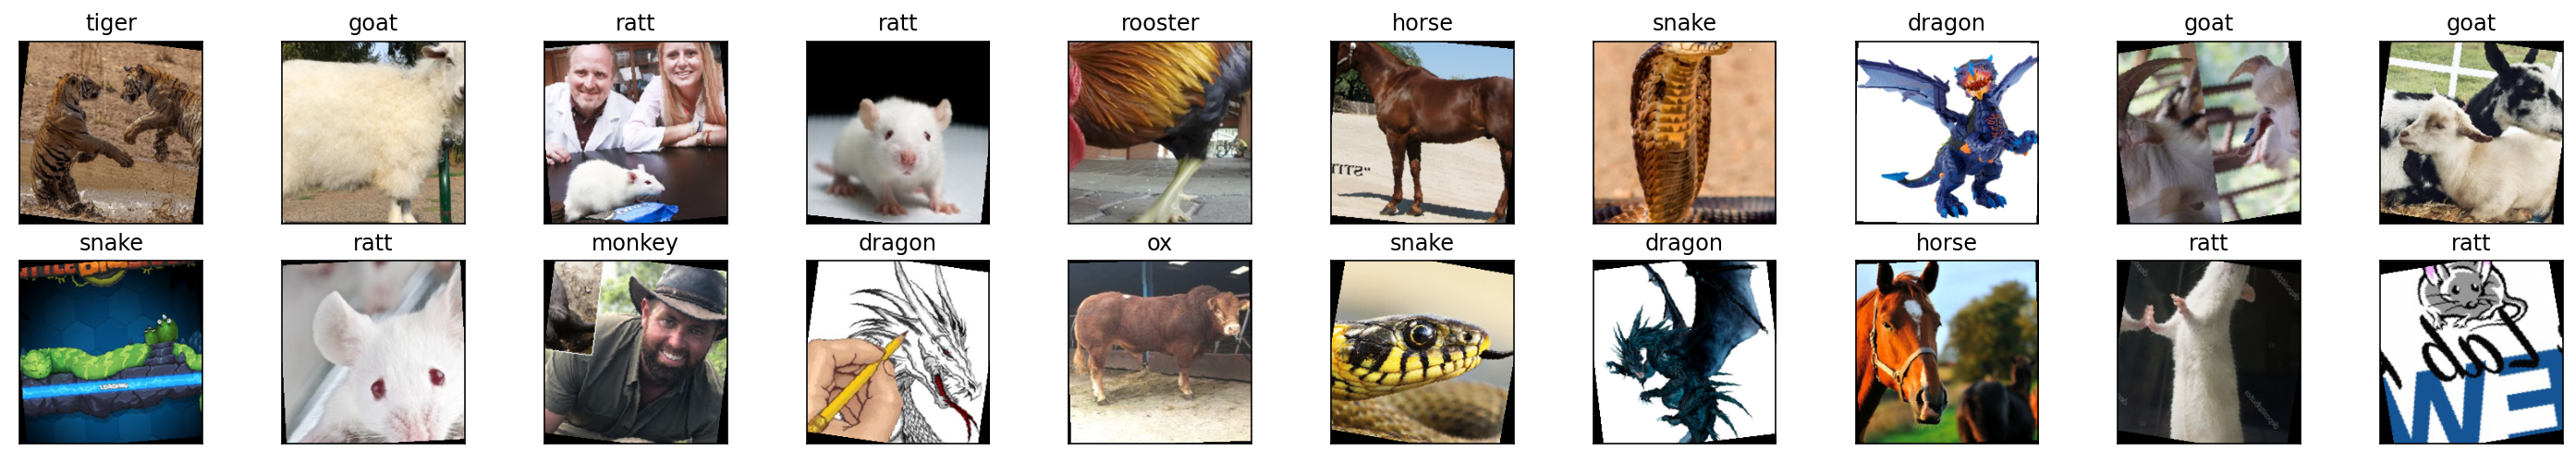

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here is a look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

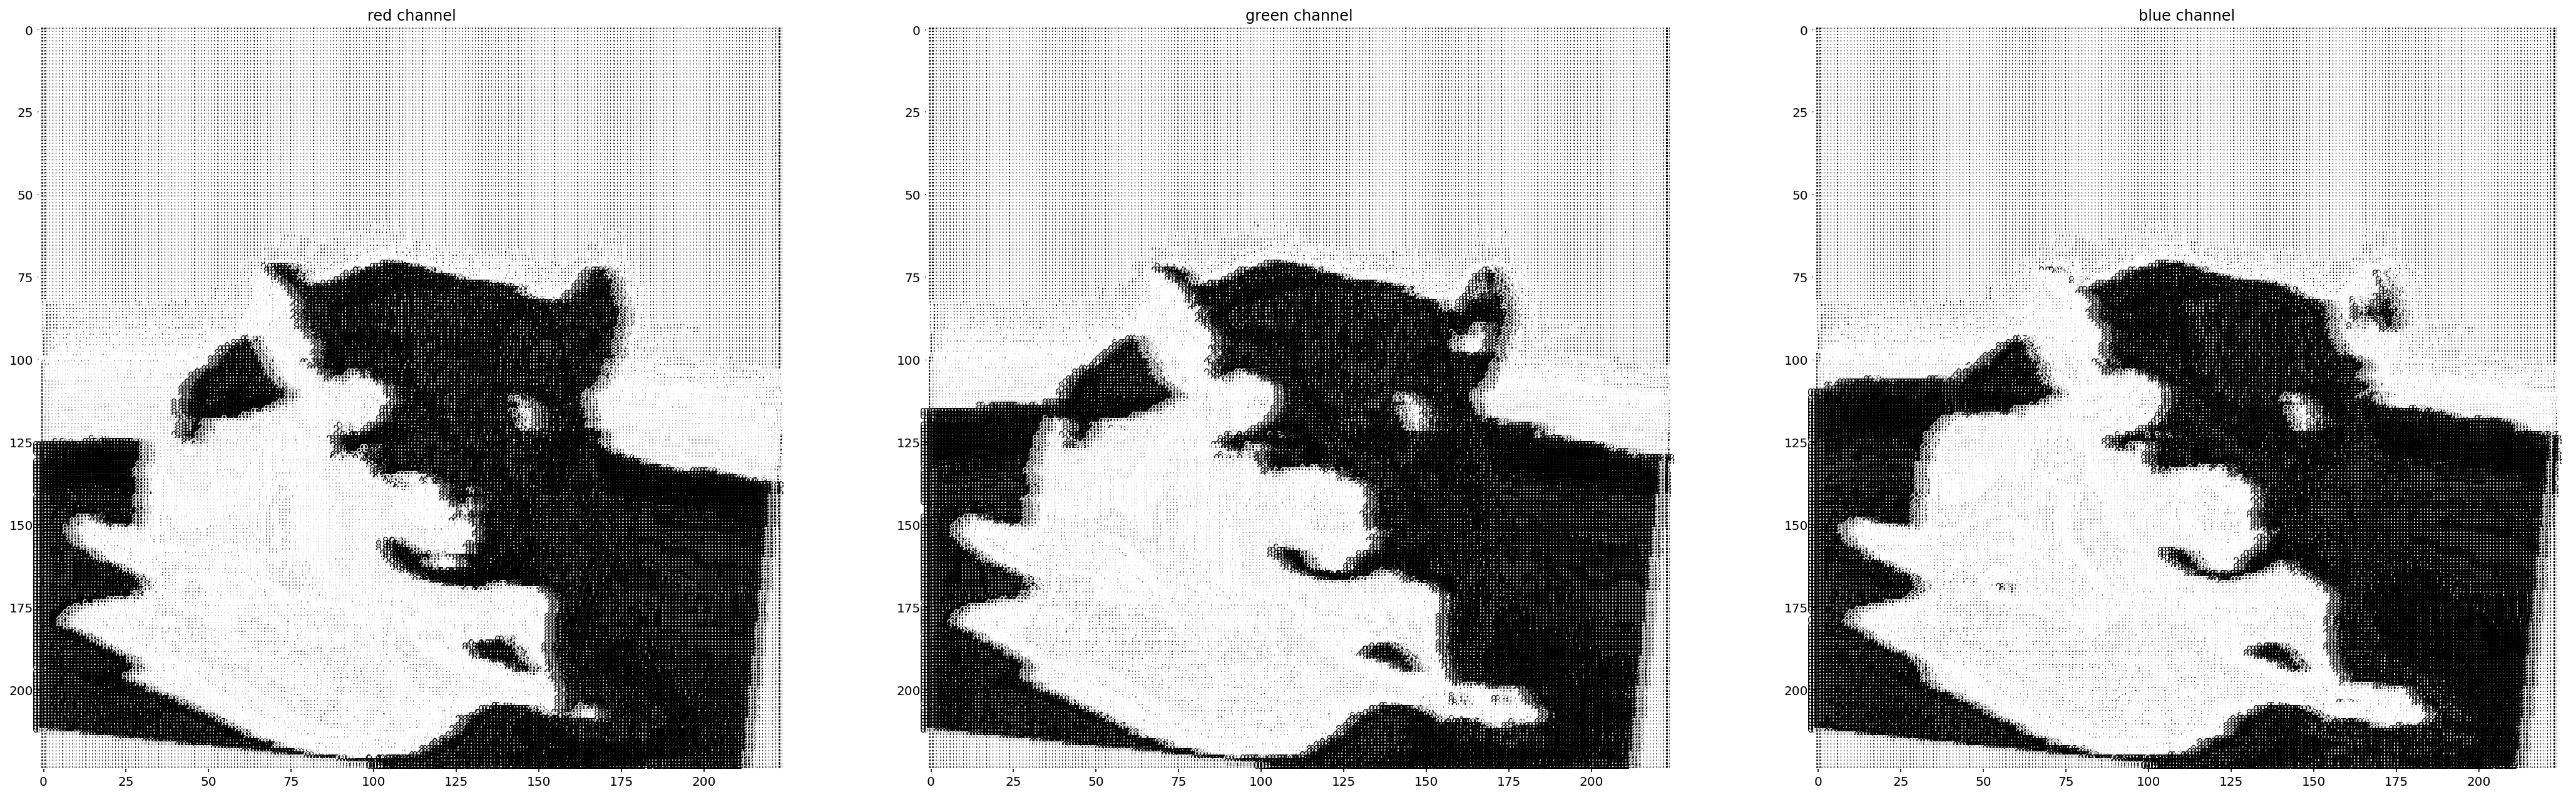

In [ ]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

Network Architecture used is **ResNet 152**

In [ ]:
# Use resnet152
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
model = torch.hub.load('pytorch/vision:v0.5.0', 'resnet152', pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 12),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)


Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

---
## Train the Network



In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model 
  
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()*data.size(0)
    
    # validate the model 
    
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
      
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'model_signs.pt')
        valid_loss_min = valid_loss

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch: 1 	Training Loss: 0.842412 	Validation Loss: 0.483154
Epoch: 2 	Training Loss: 0.539595 	Validation Loss: 0.383568
Epoch: 3 	Training Loss: 0.453416 	Validation Loss: 0.325227
Epoch: 4 	Training Loss: 0.466039 	Validation Loss: 0.359918
Epoch: 5 	Training Loss: 0.389416 	Validation Loss: 0.383820
Epoch: 6 	Training Loss: 0.401846 	Validation Loss: 0.347225
Epoch: 7 	Training Loss: 0.391557 	Validation Loss: 0.372518
Epoch: 8 	Training Loss: 0.368562 	Validation Loss: 0.313386
Epoch: 9 	Training Loss: 0.376036 	Validation Loss: 0.302314
Epoch: 10 	Training Loss: 0.312464 	Validation Loss: 0.327354
Epoch: 11 	Training Loss: 0.355741 	Validation Loss: 0.305278
Epoch: 12 	Training Loss: 0.311411 	Validation Loss: 0.320382
Epoch: 13 	Training Loss: 0.328109 	Validation Loss: 0.334836
Epoch: 14 	Training Loss: 0.334111 	Validation Loss: 0.332844
Epoch: 15 	Training Loss: 0.323358 	Validation Loss: 0.305996
Epoch: 16 	Training Loss: 0.364414 	Validation Loss: 0.354240
Epoch: 17 	Traini

###  Load the Model with the Lowest Validation Loss

In [ ]:
model.load_state_dict(torch.load('model_signs.pt'))

<All keys matched successfully>

---
## Test the Trained Network


In [ ]:
# track test loss
test_loss = 0.0
num_class = 12

class_correct = list(0. for i in range(num_class))
class_total = list(0. for i in range(num_class))

model.eval()
# iterate over test data
for data, target in test_loader:
    batch_size = data.size(0)
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(num_class):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.326175

Test Accuracy of   dog: 98% (54/55)
Test Accuracy of dragon: 85% (47/55)
Test Accuracy of  goat: 87% (48/55)
Test Accuracy of horse: 100% (55/55)
Test Accuracy of monkey: 90% (50/55)
Test Accuracy of    ox: 85% (47/55)
Test Accuracy of   pig: 98% (54/55)
Test Accuracy of rabbit: 89% (49/55)
Test Accuracy of  ratt: 87% (48/55)
Test Accuracy of rooster: 81% (45/55)
Test Accuracy of snake: 94% (52/55)
Test Accuracy of tiger: 89% (49/55)

Test Accuracy (Overall): 90% (598/660)
